In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from typing import Callable, Any
from sklearn.linear_model import LinearRegression, RANSACRegressor, Ridge, RidgeCV, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,Field,Year,Cluster,Area,Yield,Geozone,Predecessor,FAO,N_kg/ga,P_kg/ga,...,30_week_ndvi,31_week_ndvi,32_week_ndvi,33_week_ndvi,34_week_ndvi,35_week_ndvi,36_week_ndvi,37_week_ndvi,38_week_ndvi,39_week_ndvi
0,1310,2019,1,79.263,129.077355,12,0,320.0,222.330633,52.239128,...,0.757000,0.760333,0.69800,0.6610,0.60100,0.538000,0.4710,0.402333,0.347375,0.343
1,1315,2018,1,115.484,190.068235,12,0,360.0,202.932162,34.790209,...,0.734968,0.734000,0.73625,0.7140,0.68300,0.624429,0.5905,0.511000,0.463333,0.410
2,1315,2019,1,83.883,149.674818,12,0,320.0,229.686158,66.645135,...,0.693000,0.664300,0.66600,0.6230,0.57800,0.508000,0.4380,0.366667,0.333125,0.325
3,1312,2018,1,55.964,181.336145,12,0,360.0,209.345544,49.952827,...,0.751783,0.737000,0.73500,0.7095,0.68075,0.646286,0.6115,0.540000,0.476000,0.405
4,1312,2019,1,55.965,148.165017,12,0,320.0,204.983972,51.916963,...,0.735000,0.715300,0.67900,0.6650,0.63000,0.569000,0.5010,0.460714,0.399500,0.387


In [4]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

5734
5687


In [5]:
df.columns[df.isna().any()].tolist()

['FAO', 'P_kg/ga', 'K_kg/ga']

In [6]:
df.columns.tolist()

['Field',
 'Year',
 'Cluster',
 'Area',
 'Yield',
 'Geozone',
 'Predecessor',
 'FAO',
 'N_kg/ga',
 'P_kg/ga',
 'K_kg/ga',
 '5_YEARLY_median_AVERAGE_TEMPERATURE',
 '6_YEARLY_median_AVERAGE_TEMPERATURE',
 '7_YEARLY_median_AVERAGE_TEMPERATURE',
 '8_YEARLY_median_AVERAGE_TEMPERATURE',
 '9_YEARLY_median_AVERAGE_TEMPERATURE',
 '5_YEARLY_median_EVAPORATION',
 '6_YEARLY_median_EVAPORATION',
 '7_YEARLY_median_EVAPORATION',
 '8_YEARLY_median_EVAPORATION',
 '9_YEARLY_median_EVAPORATION',
 '5_YEARLY_median_HUMIDITY(%)',
 '6_YEARLY_median_HUMIDITY(%)',
 '7_YEARLY_median_HUMIDITY(%)',
 '8_YEARLY_median_HUMIDITY(%)',
 '9_YEARLY_median_HUMIDITY(%)',
 '5_YEARLY_sum_CALCULATED_RADIATION',
 '6_YEARLY_sum_CALCULATED_RADIATION',
 '7_YEARLY_sum_CALCULATED_RADIATION',
 '8_YEARLY_sum_CALCULATED_RADIATION',
 '9_YEARLY_sum_CALCULATED_RADIATION',
 '5_YEARLY_sum_RAINFALL',
 '6_YEARLY_sum_RAINFALL',
 '7_YEARLY_sum_RAINFALL',
 '8_YEARLY_sum_RAINFALL',
 '9_YEARLY_sum_RAINFALL',
 '22_WEEK_AVERAGE_TEMPERATURE',
 '23_W

In [7]:
weeks = np.arange(22, 39+1)
avg_temp_cols = [f'{w}_WEEK_AVERAGE_TEMPERATURE' for w in weeks]
calc_radiation_cols = [f'{w}_WEEK_CALCULATED_RADIATION' for w in weeks]
evaporation_cols = [f'{w}_WEEK_EVAPORATION' for w in weeks]
humidity_cols = [f'{w}_WEEK_HUMIDITY(%)' for w in weeks]
rainfall_cols = [f'{w}_WEEK_RAINFALL' for w in weeks]
sum_active_temp_cols = [f'{w}_WEEK_SUM_ACTIVE_TEMPERATURE' for w in weeks]
ndvi_cols = [f'{w}_week_ndvi' for w in weeks]

months = np.arange(5, 9+1)
history_avg_temp_cols = [f'{m}_YEARLY_median_AVERAGE_TEMPERATURE' for m in months]
history_rainfall_cols = [f'{m}_YEARLY_sum_RAINFALL' for m in months]


In [8]:
df.Predecessor.value_counts()

Predecessor
0    2015
1    1456
2    1134
3     611
4     471
Name: count, dtype: int64

Text(0.5, 0, 'Yield t/ha')

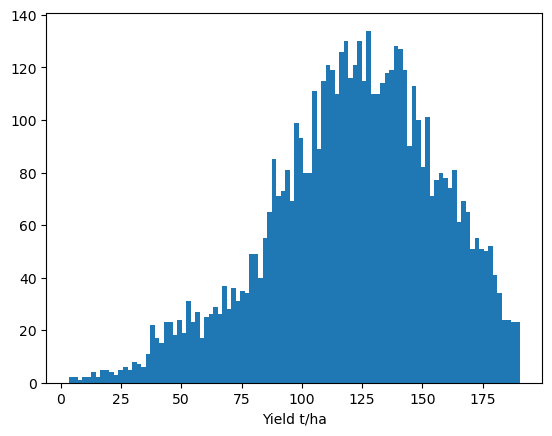

In [9]:
_ = plt.hist(df.Yield,bins=100)
plt.xlabel('Yield t/ha')

Text(0.5, 0, 'Area, ha')

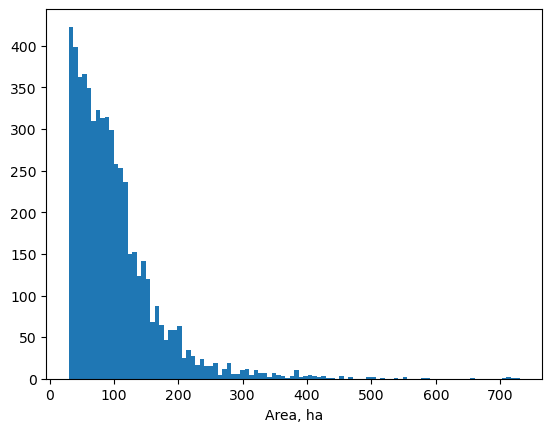

In [10]:
_ = plt.hist(df['Area'],bins=100)
plt.xlabel('Area, ha')

Text(0.5, 0, 'Average temperature, C')

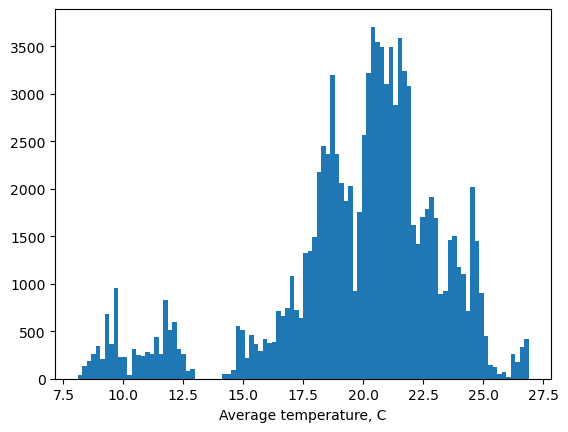

In [11]:
_ = plt.hist(df[avg_temp_cols].values.flatten(),bins=100)
plt.xlabel('Average temperature, C')

Text(0.5, 0, 'Radiation')

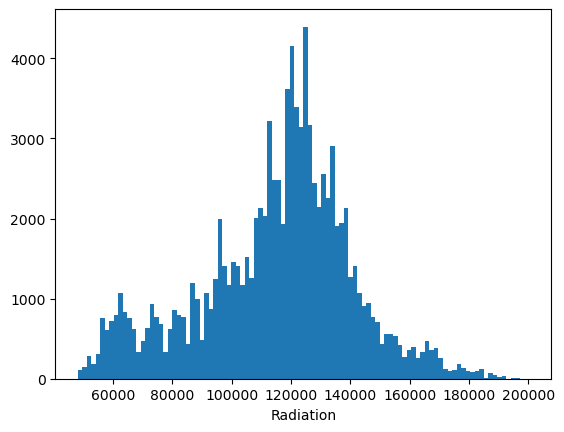

In [12]:
_ = plt.hist(df[calc_radiation_cols].values.flatten(),bins=100)
plt.xlabel('Radiation')

Text(0.5, 0, 'Evaporation')

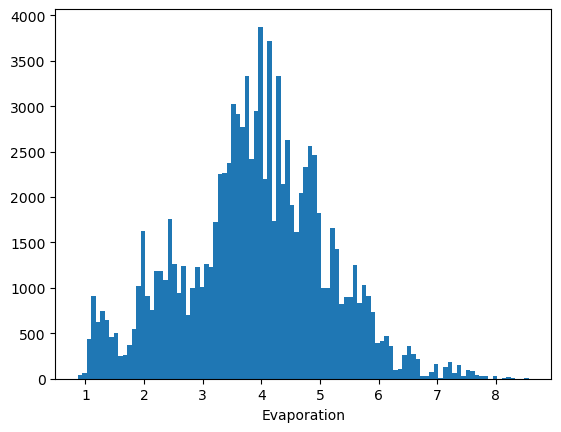

In [13]:
_ = plt.hist(df[evaporation_cols].values.flatten(),bins=100)
plt.xlabel('Evaporation')

Text(0.5, 0, 'Humidity, %')

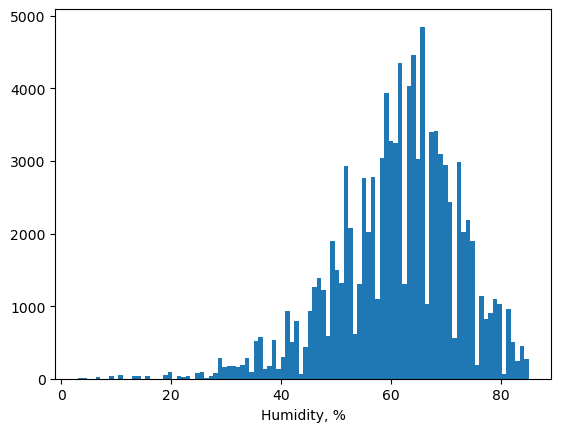

In [14]:
_ = plt.hist(df[humidity_cols].values.flatten(),bins=100)
plt.xlabel('Humidity, %')

Text(0.5, 0, 'Rainfall')

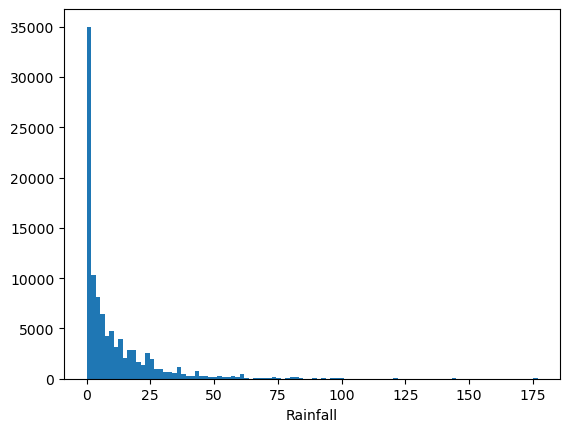

In [15]:
_ = plt.hist(df[rainfall_cols].values.flatten(),bins=100)
plt.xlabel('Rainfall')

Text(0.5, 0, 'Sum active temperatures')

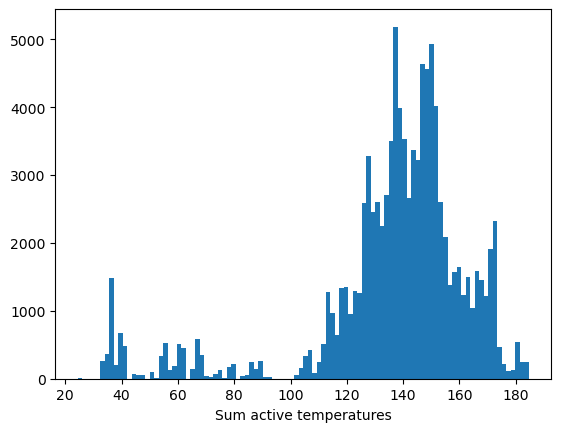

In [16]:
_ = plt.hist(df[sum_active_temp_cols].values.flatten(),bins=100)
plt.xlabel('Sum active temperatures')

Text(0.5, 0, 'NDVI')

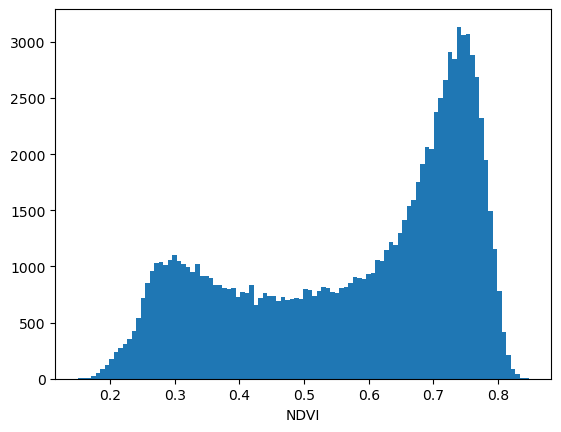

In [17]:
_ = plt.hist(df[ndvi_cols].values.flatten(),bins=100)
plt.xlabel('NDVI')

Text(0.5, 0, 'N kg/ga')

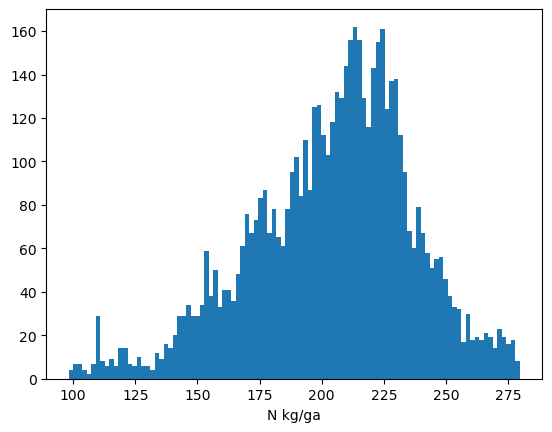

In [18]:
_ = plt.hist(df['N_kg/ga'], bins=100)
plt.xlabel('N kg/ga')

Text(0.5, 0, 'P kg/ga')

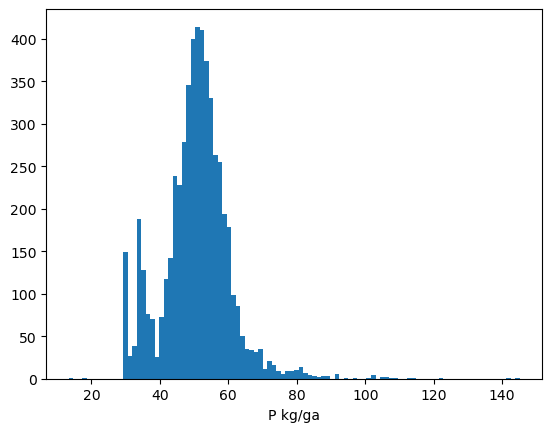

In [19]:
_ = plt.hist(df['P_kg/ga'], bins=100)
plt.xlabel('P kg/ga')

Text(0.5, 0, 'K kg/ga')

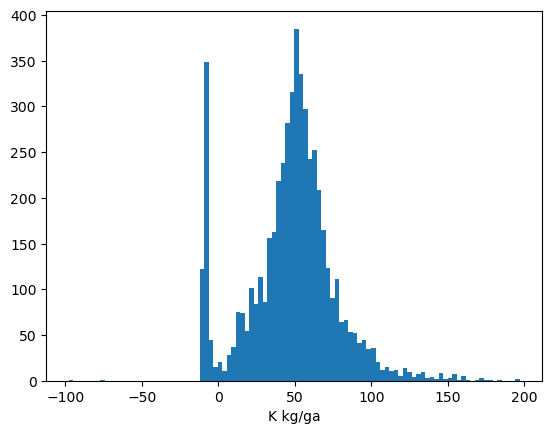

In [20]:
_ = plt.hist(df['K_kg/ga'], bins=100)
plt.xlabel('K kg/ga')

Text(0.5, 0, 'FAO')

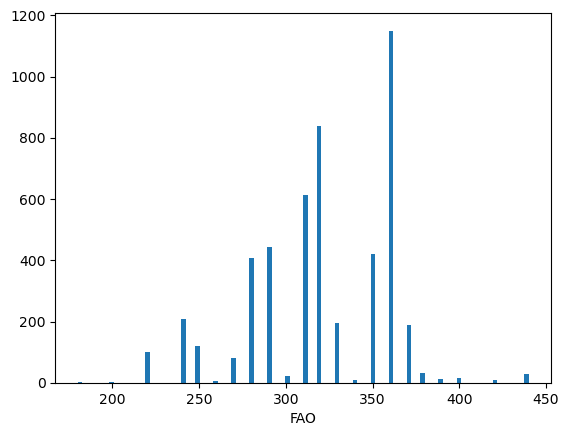

In [21]:
_ = plt.hist(df.FAO,bins=100)
plt.xlabel('FAO')

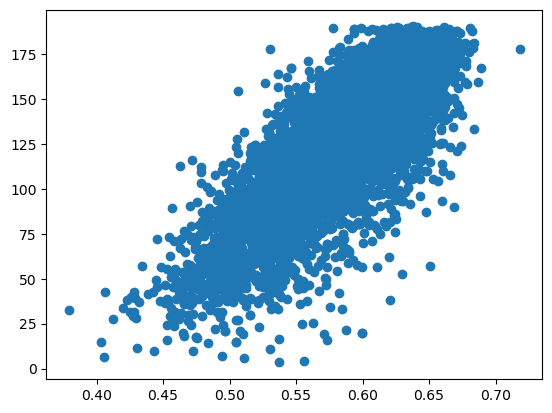

In [22]:
plt.scatter(df[ndvi_cols].values.mean(axis=1), df['Yield'])

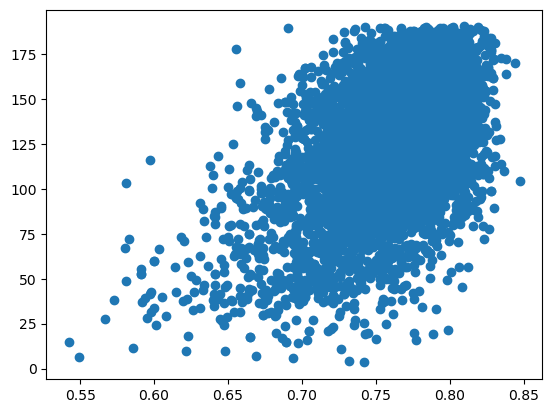

In [23]:
plt.scatter(df[ndvi_cols].values.max(axis=1), df['Yield'])

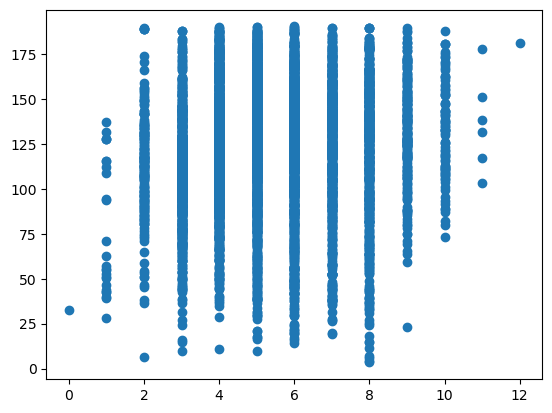

In [24]:
plt.scatter(df[ndvi_cols].values.argmax(axis=1), df['Yield'])

In [25]:
unique_clusters = np.unique(df.Cluster)
unique_predecessor = np.unique(df.Predecessor)
unique_clusters, unique_predecessor

(array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4]))

In [26]:
def calc_features(df: pd.DataFrame, add_yield=True) -> pd.DataFrame:
    res = df.copy()

    used_cols = ['Year',
         'FAO',
         'N_kg/ga',
         'P_kg/ga',
         'K_kg/ga']
    
    aggregations = {
        'avg_temp': avg_temp_cols,
        # 'radiation': calc_radiation_cols,
        # 'evaporation': evaporation_cols,
        # 'humidity': humidity_cols,
        'rainfall': rainfall_cols,
        'sum_active_temp': sum_active_temp_cols,
        'ndvi': ndvi_cols,
    }

    for agg_name, agg_cols in aggregations.items():
        values = df[agg_cols].values

        res[f'{agg_name}_mean'] = np.mean(values, axis=1)
        res[f'{agg_name}_max'] = np.max(values, axis=1)
        res[f'{agg_name}_min'] = np.min(values, axis=1)
        used_cols.extend([f'{agg_name}_mean', f'{agg_name}_max', f'{agg_name}_min'])

    weeks_in_month = 4
    tot_months = (len(weeks) + weeks_in_month-1)//weeks_in_month
    month_aggregations = {
        'avg_temp': avg_temp_cols,
        'rainfall': rainfall_cols,
        'sum_active_temp': sum_active_temp_cols,
        'ndvi': ndvi_cols,
    }

    for agg_name, agg_cols in month_aggregations.items():
        values = df[agg_cols].values
        for m in range(tot_months):
            i = m*weeks_in_month
            j = min((m+1)*weeks_in_month, len(weeks))
            wi = weeks[i]
            wj = weeks[j-1]
            col = f'{agg_name}_{wi}:{wj}_mean'
            res[col] = np.mean(values[:, i:j], axis=1)
            used_cols.append(col)

    history_aggregations = {
        'hist_avg_temp': history_avg_temp_cols,
        'hist_rainfall': history_rainfall_cols
    }

    for agg_name, agg_cols in history_aggregations.items():
        res[agg_name] = np.mean(res[agg_cols].values, axis=1)
        used_cols.append(agg_name)
    

    # rainfall_values = res[rainfall_cols].values
    # for rainfall_thr in [1,5,10,25]:
    #     col = f'rainfall_cnt_thr={rainfall_thr}'
    #     res[col] = np.sum(rainfall_values>=rainfall_thr, axis=1)
    #     used_cols.append(col)

    onehot_cols = {'Predecessor': unique_predecessor
                  }
    for onehot_col, onehot_col_values in onehot_cols.items():
        for value in onehot_col_values:
            col = f'{onehot_col}={value}'
            res[col] = res[onehot_col]==value
            used_cols.append(col)


    res['ndvi_max_idx'] = np.argmax(values, axis=1)
    used_cols.append('ndvi_max_idx')

    if add_yield:
        used_cols.append('Yield')
    
    return res[used_cols]

df_features = calc_features(df, add_yield=True)
missing_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        
missing_imputer.fit(df_features)
df_features[:] = missing_imputer.transform(df_features)

scaled_columns = df_features.columns.tolist()[1:-1]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features[scaled_columns])
print(df_features.shape, features_scaled.shape)
df_features_scaled = pd.DataFrame(features_scaled, index=df_features.index, columns=scaled_columns)
df_features_scaled['Year'] = df_features['Year']
df_features_scaled['Yield'] = df_features['Yield']

(5687, 46) (5687, 44)


In [27]:
df_features_scaled.head()

,FAO,N_kg/ga,P_kg/ga,K_kg/ga,avg_temp_mean,avg_temp_max,avg_temp_min,rainfall_mean,rainfall_max,rainfall_min,...,hist_avg_temp,hist_rainfall,Predecessor=0,Predecessor=1,Predecessor=2,Predecessor=3,Predecessor=4,ndvi_max_idx,Year,Yield
0,-0.011286,0.553214,0.160941,0.107977,-1.148609,-0.493008,0.723506,0.078699,-0.340334,-0.172889,...,-1.54595,1.257055,1.349938,-0.586623,-0.499066,-0.346944,-0.300498,0.334860,2019,129.077355
1,1.069092,-0.036489,-1.621144,-1.005835,-0.451203,-1.539201,-0.355661,2.004922,1.469365,1.602198,...,-1.54595,1.257055,1.349938,-0.586623,-0.499066,-0.346944,-0.300498,-0.731405,2018,190.068235
2,-0.011286,0.776818,1.632248,1.180978,-1.148609,-0.493008,0.723506,0.078699,-0.340334,-0.172889,...,-1.54595,1.257055,1.349938,-0.586623,-0.499066,-0.346944,-0.300498,-0.731405,2019,149.674818
3,1.069092,0.158475,-0.072563,-0.376251,-0.451203,-1.539201,-0.355661,2.004922,1.469365,1.602198,...,-1.54595,1.257055,1.349938,-0.586623,-0.499066,-0.346944,-0.300498,1.401125,2018,181.336145
4,-0.011286,0.025885,0.128037,0.033198,-1.148609,-0.493008,0.723506,0.078699,-0.340334,-0.172889,...,-1.54595,1.257055,1.349938,-0.586623,-0.499066,-0.346944,-0.300498,0.867992,2019,148.165017


In [28]:
df_features.head()

,Year,FAO,N_kg/ga,P_kg/ga,K_kg/ga,avg_temp_mean,avg_temp_max,avg_temp_min,rainfall_mean,rainfall_max,...,ndvi_38:39_mean,hist_avg_temp,hist_rainfall,Predecessor=0,Predecessor=1,Predecessor=2,Predecessor=3,Predecessor=4,ndvi_max_idx,Yield
0,2019,320.0,222.330633,52.239128,51.227811,19.252778,24.260000,10.880000,11.200000,42.3,...,0.345187,17.96948,784.802,1.0,0.0,0.0,0.0,0.0,6,129.077355
1,2018,360.0,202.932162,34.790209,19.425721,19.597977,23.084831,9.698932,19.025556,96.0,...,0.436667,17.96948,784.802,1.0,0.0,0.0,0.0,0.0,4,190.068235
2,2019,320.0,229.686158,66.645135,81.864650,19.252778,24.260000,10.880000,11.200000,42.3,...,0.329063,17.96948,784.802,1.0,0.0,0.0,0.0,0.0,4,149.674818
3,2018,360.0,209.345544,49.952827,37.401901,19.597977,23.084831,9.698932,19.025556,96.0,...,0.440500,17.96948,784.802,1.0,0.0,0.0,0.0,0.0,8,181.336145
4,2019,320.0,204.983972,51.916963,49.092690,19.252778,24.260000,10.880000,11.200000,42.3,...,0.393250,17.96948,784.802,1.0,0.0,0.0,0.0,0.0,7,148.165017


In [29]:
def root_mean_square_error(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def year_kfold_fit_predict(X: pd.DataFrame, 
                           train_func: Callable[[pd.DataFrame, np.ndarray], Any]):
    years = np.unique(X['Year'])
    all_metrics = []
    all_gt_yield = []
    all_pred_yield = []
    all_models = []

    for year in years:
        train_years = years.tolist()
        train_years.remove(year)
        val_years = [year]

        ds_train = X[X.Year.isin(train_years)].copy()
        ds_val = X[X.Year.isin(val_years)].copy()

        x_train = ds_train.drop(columns=['Year', 'Yield'])
        x_val = ds_val.drop(columns=['Year', 'Yield'])
        y_train = ds_train['Yield'].values
        y_val = ds_val['Yield'].values

        model = train_func(x_train, y_train)

        yield_pred = model.predict(x_val)
        metric = root_mean_square_error(y_val, yield_pred)
        # all_gt_yield.append(yield_gt)
        # all_pred_yield.append(yield_pred)
        all_metrics.append(metric)
        print(f'{year= } RMSE= {metric:.02f}')
        all_models.append(model)

    print(f'All years RMSE= {np.mean(all_metrics):.02f}')
    # plt.scatter(np.concatenate(all_gt_yield), np.concatenate(all_pred_yield))
    return all_models


In [30]:
def train_linear_regression(x: pd.DataFrame, y: np.ndarray) -> LinearRegression:
    model = LinearRegression()
    model.fit(x, y)
    return model

simple_linear_models = year_kfold_fit_predict(df_features_scaled, train_linear_regression)    

year= 2016 RMSE= 21.65
year= 2017 RMSE= 33.37
year= 2018 RMSE= 30.14
year= 2019 RMSE= 39.13
All years RMSE= 31.07


In [31]:
def train_randomforest(x: pd.DataFrame, y: np.ndarray) -> LinearRegression:
    model = RandomForestRegressor()
    model.fit(x, y)
    return model

rf_models = year_kfold_fit_predict(df_features_scaled, train_randomforest)

year= 2016 RMSE= 23.95
year= 2017 RMSE= 28.23
year= 2018 RMSE= 26.20
year= 2019 RMSE= 18.81
All years RMSE= 24.30


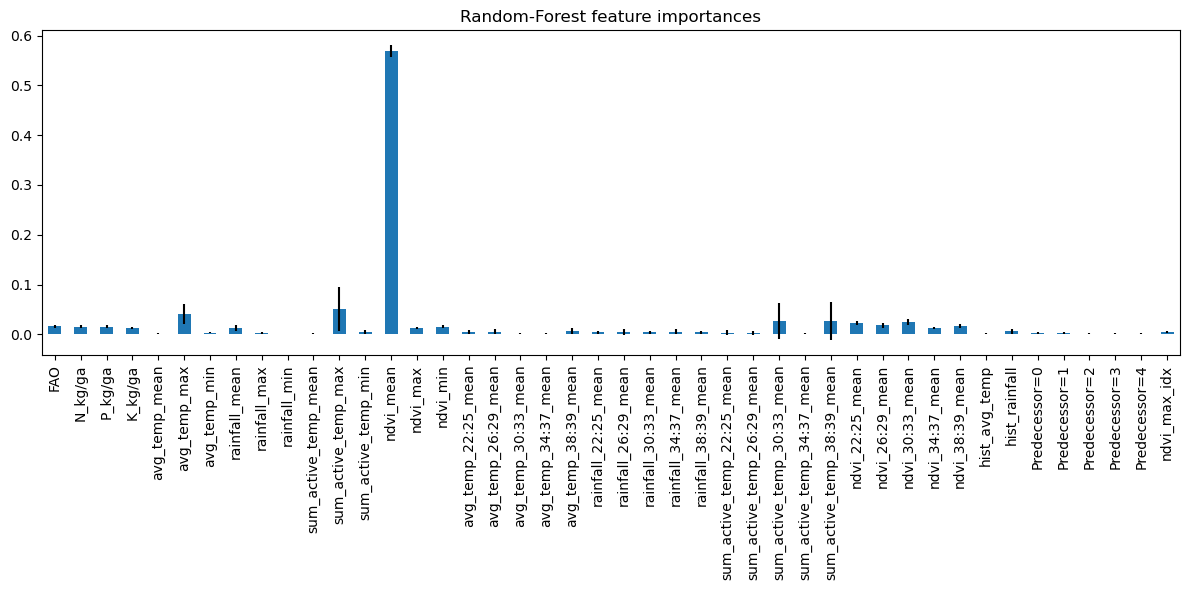

In [32]:
rf_importances = pd.Series(rf_models[0].feature_importances_, index=df_features.drop(columns=['Year', 'Yield']).columns.tolist())
std = np.std([tree.feature_importances_ for tree in rf_models[0].estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12,6))
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random-Forest feature importances")
fig.tight_layout()

In [33]:
df_test = pd.read_csv('data/test.csv')

In [34]:
df_test_features = calc_features(df_test, add_yield=True)
df_test_features[:] = missing_imputer.transform(df_test_features)

test_features_scaled = scaler.transform(df_test_features[scaled_columns])
print(df_features.shape, features_scaled.shape)
df_test_features_scaled = pd.DataFrame(test_features_scaled, index=df_test_features.index, columns=scaled_columns)

(5687, 46) (5687, 44)


In [35]:
df_test_features_scaled.shape

(2192, 44)

In [36]:
all_predicted_yield = []
for m in rf_models:
    pred = m.predict(df_test_features_scaled)
    all_predicted_yield.append(pred)

In [37]:
pred_yield = np.mean(np.stack(all_predicted_yield, axis=1), axis=1)

Text(0.5, 0, 'Predicted yield t/ha')

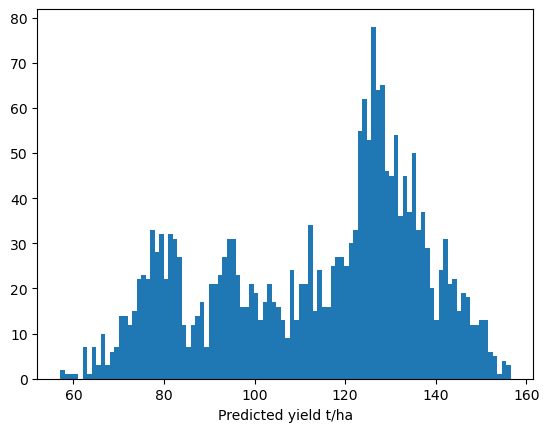

In [38]:
_ = plt.hist(pred_yield, bins=100)
plt.xlabel('Predicted yield t/ha')

In [39]:
df_test['Yield'] = pred_yield
df_test.to_csv('test_predicted_yield.csv', index=False)

In [40]:
all_years = []
all_clusters = []
all_wca = []
for (year, cluster), group in df_test.groupby(['Year', 'Cluster']):
    Yield = group['Yield'].values
    Area = group['Area'].values
    weighted_cluster_average = np.sum(Yield*Area)/np.sum(Area)

    all_years.append(year)
    all_clusters.append(cluster)
    all_wca.append(weighted_cluster_average)

df_test_pred_by_cluster = pd.DataFrame({'Year': all_years, 'Cluster': all_clusters, 'WeighterClusterAverage': all_wca})
df_test_pred_by_cluster

    

,Year,Cluster,WeighterClusterAverage
0,2020,0,124.198370
1,2020,1,128.713066
2,2020,2,78.519530
3,2020,3,77.476098
4,2020,4,91.685083
5,2020,5,68.610881
6,2020,6,84.607265


In [41]:
df_test_pred_by_cluster.to_csv('test_predicted_yield_by_cluster.csv', index=False)